# Background

Hi, thanks for giving me the chance to showcasing my data science skills. The dataset I'll be working with in this mini project is 'ds_salaries.csv', publically available on Kaggle (link in README). I'll be doing some EDA, data pre-processing, fitting different models, and explaining my decisions behind what I do as I do so. The goal is to ultimately have a passable model that can reasonably predict salary based off the features in this dataset. I chose this topic mostly because I thought it was funny to do a report on data science salaries as I am applying for the exact same kind of work -- and yes, at the end I'll be fitting a data point representing myself for a predicted value.  





# 0. Preliminary Setup

Loading some basic data science packages as well as the data. 

In [28]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
plt.rcParams['figure.figsize'] = [15, 5]
sns.set_style("darkgrid")

raw_data = pd.read_csv('ds_salaries.csv', index_col=0)
raw_data.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L


# 1. Basic EDA and Inspection of the Dataset 

## 1.a. Description of data 

The dataset contains 607 samples and a total of 11 columns. Briefly summarized, 
- `work_year` is the year the data point is reported
- `experience_level` refers to the experience of the role (entry, junior, senior, executive) 
- `employment_type` refers to if the role if full-time, part-time, contract or freelance
- `salary`, `salary_currency`, `salary_in_usd` are salaries. **This is what our response is.**
- `employee_residence` is the country the employee is working in 
- `remote_ratio` is how "remote" the position is (on-site, hybrid or mostly/fully remote)
- `company_location` is where the company is based
- `company_size` is the amount of employees the company has, grouped into small, medium, or large

A more comprehensive overview of these data columns is on Kaggle. 

A quick note: based on the description and the way the data is structured, *every* predictor (excluding salary) is categorical, even though there are integer based dtypes for some columns. This is something I will touch upon later during modelling.  


In [6]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 607 entries, 0 to 606
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           607 non-null    int64 
 1   experience_level    607 non-null    object
 2   employment_type     607 non-null    object
 3   job_title           607 non-null    object
 4   salary              607 non-null    int64 
 5   salary_currency     607 non-null    object
 6   salary_in_usd       607 non-null    int64 
 7   employee_residence  607 non-null    object
 8   remote_ratio        607 non-null    int64 
 9   company_location    607 non-null    object
 10  company_size        607 non-null    object
dtypes: int64(4), object(7)
memory usage: 56.9+ KB


## 1.b. Problem-checking

Before beginning anything, I should check to see if there's any issues with the data set. The code below checks for any null values.


In [5]:
print(raw_data.isnull().sum())

work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64


Wonderful, no null values. If there was, I would go with a KNearestNeighbours imputation -- intuition tells me it would be more accurate than less sophisticated methods like imputation by median value. We should also check the distribution of salary to quickly infer if there will be bad leverage points (outliers) that should be addressed.

<AxesSubplot:xlabel='salary_in_usd'>

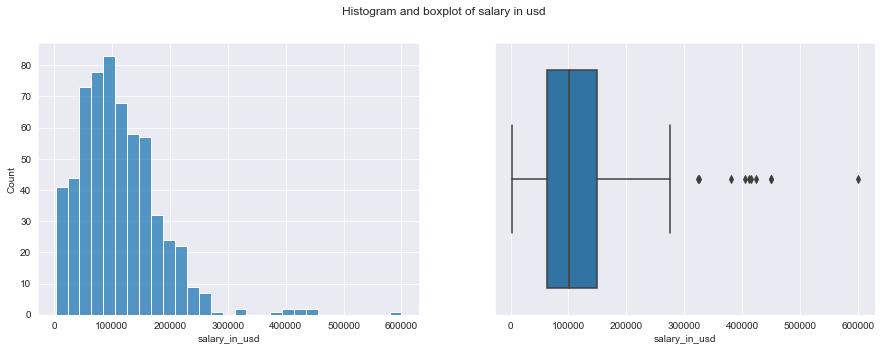

In [29]:
fig, ax =plt.subplots(1,2)
fig.suptitle('Histogram and boxplot of salary in usd')
sns.histplot(x='salary_in_usd', data=raw_data, ax=ax[0])
sns.boxplot(x='salary_in_usd', data=raw_data, ax=ax[1])


Well, the distribution of salary is definitely right skewed, and the severity/infrequency of the outliers will noticeably impact model estimates as well as challenge the normality of residuals assumption for linear models. This will be something that we would need to address down the line during pre-processing. On the plus side, there aren't any negative values for salary so I presume data quality is reasonable (at least, not nonsensical).

## 1.c. EDA 

Here I plot some possibly relevant relationships between salary and predictors. This is not intended to be comprehensive.

[Text(0.5, 1.0, 'salary as grouped by employment type')]

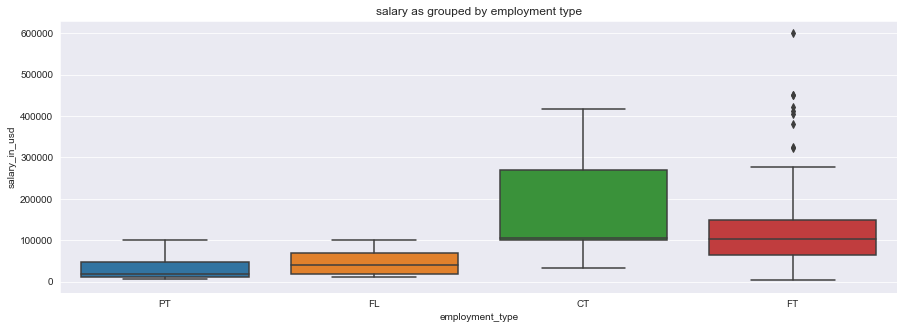

In [32]:
sns.boxplot(x="employment_type", y="salary_in_usd", data=raw_data, order=['PT','FL','CT','FT']).set(title="salary as grouped by employment type")




[Text(0.5, 1.0, 'salary as grouped by work year')]

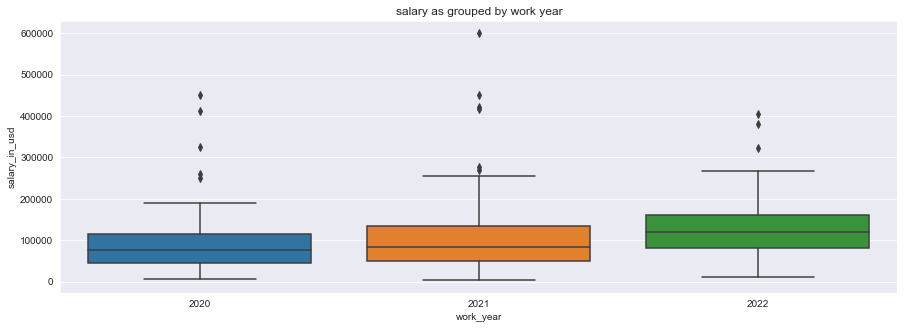

In [35]:
sns.boxplot(x="work_year", y="salary_in_usd", data=raw_data).set(title="salary as grouped by work year")

[Text(0.5, 1.0, 'salary as grouped by experience level')]

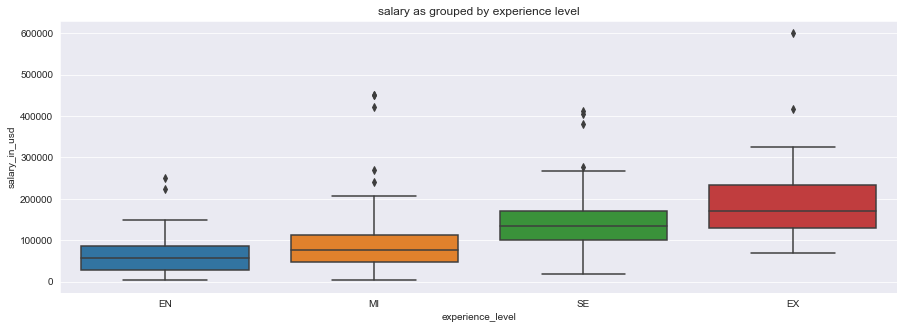

In [33]:
sns.boxplot(x="experience_level", y="salary_in_usd", data=raw_data, order=['EN','MI','SE','EX']).set(title="salary as grouped by experience level")

[Text(0.5, 1.0, 'salary as grouped by company size')]

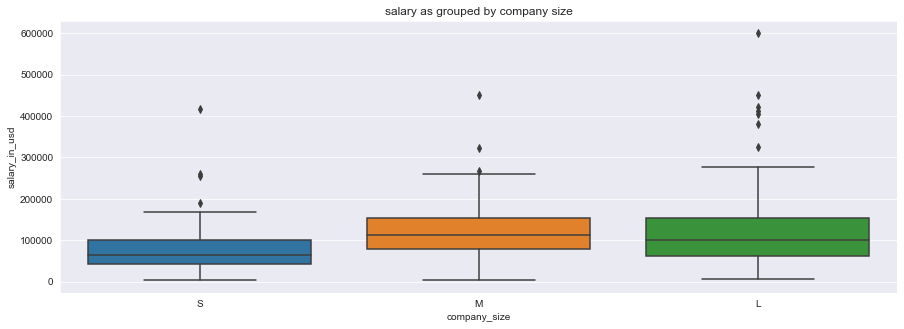

In [43]:
sns.boxplot(x="company_size", y="salary_in_usd", data=raw_data, order=['S','M','L']).set(title="salary as grouped by company size")

[Text(0.5, 1.0, 'Count of employment type in dataset')]

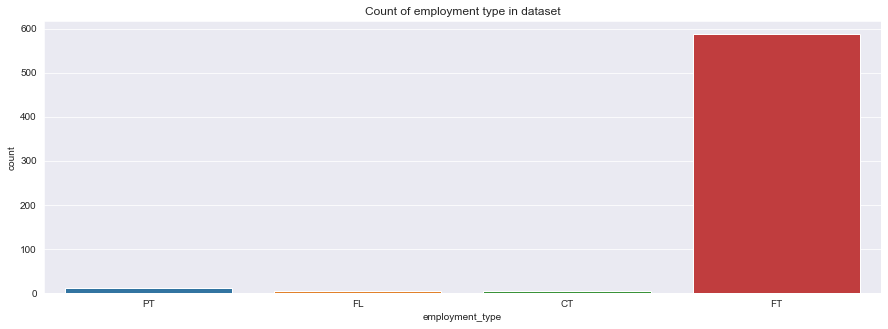

In [40]:
sns.countplot(x="employment_type",data=raw_data,order=['PT','FL','CT','FT']).set(title="Count of employment type in dataset")

[Text(0.5, 1.0, 'Count of experience levels in dataset')]

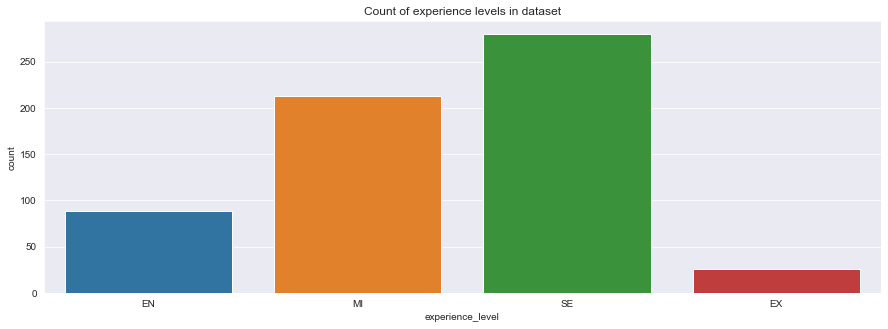

In [42]:
sns.countplot(x="experience_level",data=raw_data, order=['EN','MI','SE','EX']).set(title="Count of experience levels in dataset")

[Text(0.5, 1.0, 'Count of work year in dataset')]

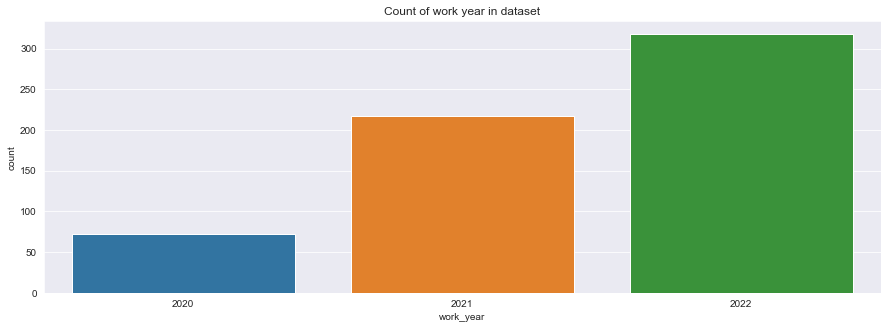

In [39]:
sns.countplot(x="work_year",data=raw_data).set(title="Count of work year in dataset")

From our EDA, some obvious (yet important-to-verify from a common sense standpoint) notions are that average salary increases as you raise your experience level, and similarly the same occurs for employment type (although oddly enough a majority of contractors are paid surprising well). Medium and large companies on average pay better than small companies, with a lot more outliers for large companies. Surprisingly, as you increase work year it seems that average salary also increases.

A vast majority of data comes from full time junior/senior roles and from 2022.

Finally, a logical data visual would be to check job titles against salary, since you typically refer to average salary by job titles in the real world anyway. Unfortunately, in it's un-processed state it would be cumbersome to do so; for an obvious reason, see the output of the code below:


In [34]:
print(raw_data.job_title.unique())

['Data Scientist' 'Machine Learning Scientist' 'Big Data Engineer'
 'Product Data Analyst' 'Machine Learning Engineer' 'Data Analyst'
 'Lead Data Scientist' 'Business Data Analyst' 'Lead Data Engineer'
 'Lead Data Analyst' 'Data Engineer' 'Data Science Consultant'
 'BI Data Analyst' 'Director of Data Science' 'Research Scientist'
 'Machine Learning Manager' 'Data Engineering Manager'
 'Machine Learning Infrastructure Engineer' 'ML Engineer' 'AI Scientist'
 'Computer Vision Engineer' 'Principal Data Scientist'
 'Data Science Manager' 'Head of Data' '3D Computer Vision Researcher'
 'Data Analytics Engineer' 'Applied Data Scientist'
 'Marketing Data Analyst' 'Cloud Data Engineer' 'Financial Data Analyst'
 'Computer Vision Software Engineer' 'Director of Data Engineering'
 'Data Science Engineer' 'Principal Data Engineer'
 'Machine Learning Developer' 'Applied Machine Learning Scientist'
 'Data Analytics Manager' 'Head of Data Science' 'Data Specialist'
 'Data Architect' 'Finance Data Anal

A lot of these roles should actually be grouped together (what exactly is the distinction in role and responsibility between 'data analyst' and 'product data analyst'?), but isn't in it's current form. Part of data-processing will address this. 

Another obvious visualization would be correlation heatmaps or scatterplots, however by design all of our features are currently un-encoded categorical features; I can't do this since correlation require numerical values.

# 2. Data Pre-processing

Here is actually where most of the work will go -- in my experience, this is the 'science' behind data science. For brevity, I'll be using sklearn's Pipelines, but in doc-strings I'll list what the actual methods/functions are doing.


In [114]:
data = raw_data.copy() # making a copy of the data is not necessary, but convenient if I need to roll back any changes


## 2.a. Salary, in Canadian Dollars

It is totally redundant to have 3 salary columns, and using any of the remaning 2 as features is peak data leakage. Moreover, it is more relevant to have salary to be in Canadian dollars anyway. As a bonus, I get to address how vectorization is used.

Here I drop all 3 columns and replace them with `salary_in_cad`.

In [115]:
"""Creating 'salary_in_cad' the fast way (vectorized) and dropping the original salary columns"""
data['salary_in_cad'] = data['salary_in_usd'] * 1.28 # conversion rate as of Aug 2022
data = data.drop(columns=['salary', 'salary_currency', 'salary_in_usd'])

"""Creating 'salary_in_cad' the fast way (vectorized) but kinda obtuse"""
""" 
data['salary_in_cad'] = data['salary_in_usd'].apply(lambda x: x*1.28)
"""

"""Creating 'salary_in_cad' the slow way (non-vectorized)"""

""" 
salary_in_cad = np.array()
for idx, row in data.iterrows():
    salary_in_cad.append(row['salary_in_usd'] * 1.28)
"""


" \nsalary_in_cad = np.array()\nfor idx, row in data.iterrows():\n    salary_in_cad.append(row['salary_in_usd'] * 1.28)\n"

## 2.b. Ordinal encoding 

There are some categorical features that have a natural order to them with respect to salary - we should expect that, all else being equal, a senior-level role will pay more than a junior-level role.

The ordinal variables are `experience_level` and `company_size`. Actually encoding them would be in the pipeline section.

In [116]:
ordinal_columns = ['experience_level', 'company_size'] # ordinal columns
experience_level_order = ['EN', 'MI', 'SE', 'EX'] # exp. level order
company_size_order = ['S','M','L'] # company size order

"""
This code block represents what the OrdinalEncoder does in the pipeline.

from sklearn.preprocessing import OrdinalEncoder
enc_exp_level = OrdinalEncoder(categories=[['EN', 'MI', 'SE', 'EX'],['S','M','L']]) # Ordinal variables are work exp and company size
data[['experience_level', 'company_size']] = enc_exp_level.fit_transform(data[['experience_level','company_size']])
print(enc_exp_level.categories_)
"""


"\nThis code block represents what the OrdinalEncoder does in the pipeline.\n\nfrom sklearn.preprocessing import OrdinalEncoder\nenc_exp_level = OrdinalEncoder(categories=[['EN', 'MI', 'SE', 'EX'],['S','M','L']]) # Ordinal variables are work exp and company size\ndata[['experience_level', 'company_size']] = enc_exp_level.fit_transform(data[['experience_level','company_size']])\nprint(enc_exp_level.categories_)\n"

## 2.c. Categorical encoding

All the remaining predictors. Creates dummy variables in place of the original columns, since models require numeric inputs. Encoded in pipeline step.

In [64]:
"""
The code below represents what the pipeline would essentially do for nominal columns. 

nominal_columns = data.columns[data.columns.map(lambda x: x not in ['experience_level', 'company_size', 'salary_in_cad'])].values
#print(nominal_columns)
data = pd.get_dummies(data=data, columns=nominal_columns, drop_first=True)
"""

['work_year' 'employment_type' 'job_title' 'employee_residence'
 'remote_ratio' 'company_location']


'\nThe code below represents what the pipeline would essentially do for nominal columns. \n\ndata = pd.get_dummies(data=data, columns=nominal_columns, drop_first=True)\n'

Given the wide amount of possible responses for certain kinds of information, our models will invariable have a large amount of unnecessary dummy variables. Analysis would be therefore quite unwieldy, with potentially really high multicollinearity, overfitting, or sparsity issues. 

My approach to this problem is to 1) group employee residence such that non-NA locations are simply grouped as 'Other', and 2) reduce company location into a binary variable where it returns a 1 if company location matches employee residence and 0 otherwise.



In [117]:
data['employee_residence'] = data.employee_residence.apply(lambda x: 'Other' if x not in ('US', 'CA') else x) # another vectorized function
data['company_location'] = np.where(data['company_location']==data['employee_residence'], 1, 0) # binarize company location

## 2.d. Regrouping Job Titles

Recall that there are about ~50 titles in the dataset. Most roles comfortably fall under 'engineer', 'scientist', 'analyst' or leadership positions (the remainder roles will be grouped as other if their roles are ambiguous). This step is also done at the pipeline step, but the (empty) code block below describes the custom transformer I've written to do this. This class is written in the helper_class_and_functions.py file. The function is also vectorized.


In [ ]:
""" 
Empty block because I'll be running it in the pipeline step.

import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin

class JobTitleTransformer(BaseEstimator,TransformerMixin):

    def transform(self, X, y=None):
        job_group = pd.Series(X["job_title"].apply(lambda x: 'Senior' if ('Lead' in x or 'Principal' in x or 'Head' in x or 'Director' in x or 'Manager' in x) else x))
        job_group = job_group.map(lambda x: x.split(' ')[-1])
        job_group = job_group.map(lambda x: 'Other' if ('Architect' in x or 'Consultant' in x or 'Developer' in x or 'Researcher' in x or 'Specialist' in x) else x)
        X = X.drop(columns=["job_title"])
        return X.merge(job_group.rename('job_group'), left_index=True, right_index=True)

    def fit(self, X, y=None):
        return self
"""

In [118]:
print(data.columns)

Index(['work_year', 'experience_level', 'employment_type', 'job_title',
       'employee_residence', 'remote_ratio', 'company_location',
       'company_size', 'salary_in_cad'],
      dtype='object')


# 2.e. Putting it together: Data pipelines...sorta.

If any of the above is read at all I could have processed each step individually. However, I chose to do it through pipelines because it's more convenient and can be automated in some sense (at the very least, it will pare down the amount of rewritten code for different types of transformations on the same dataset)... is what I'd like to say and in fact do, but turns out I have some issues and this takes a really long time to debug, so nevermind. Back to the old ways I go.

**Technical notes**: You typically need to create separate pipelines for numeric and non-numeric data, but all we have is non-numeric so an additional pipeline is unnecessary. You would also split the data first into training and testing sets and fitting the pipeline only to the training set in order to prevent data leakage (e.g. if the pipeline had an imputation or scaling step), but in our specific case there's no processing we've done that would leak any information.


In [119]:
from sklearn.pipeline import Pipeline 
from helper_class_and_functions import JobTitleTransformer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer

job_pipeline = Pipeline([
    ('job', JobTitleTransformer())
])
data = job_pipeline.fit_transform(data)


In [120]:
from sklearn.preprocessing import OrdinalEncoder

# If only I could specify columns using strings with np arrays... alas.

enc_exp_level = OrdinalEncoder(categories=[['EN', 'MI', 'SE', 'EX'],['S','M','L']]) # Ordinal variables are work exp and company size
data[['experience_level', 'company_size']] = enc_exp_level.fit_transform(data[['experience_level','company_size']])

nominal_columns = data.columns[data.columns.map(lambda x: x not in ['experience_level', 'company_size', 'salary_in_cad'])].values
data = pd.get_dummies(data=data, columns=nominal_columns, drop_first=True)


So, our almost completed/prepared data now looks like:

In [121]:
data.head()

,experience_level,company_size,salary_in_cad,work_year_2021,work_year_2022,employment_type_FL,employment_type_FT,employment_type_PT,employee_residence_Other,employee_residence_US,remote_ratio_50,remote_ratio_100,company_location_1,job_group_Engineer,job_group_Other,job_group_Scientist,job_group_Senior
0,1.0,2.0,102186.24,0,0,0,1,0,1,0,0,0,0,0,0,1,0
1,2.0,0.0,332800.00,0,0,0,1,0,1,0,0,0,0,0,0,1,0
2,2.0,1.0,139550.72,0,0,0,1,0,1,0,1,0,0,1,0,0,0
3,1.0,0.0,25600.00,0,0,0,1,0,1,0,0,0,0,0,0,0,0
4,2.0,2.0,192000.00,0,0,0,1,0,0,1,1,0,1,1,0,0,0


## 2.f. Diagnostics plots and transforming our response

Recalling the days back in a regression class, part of the validity of our analysis hinges on how well the data satisfies the requisite assumptions, and that means looking at diagnostic plots. Unfortunately, at its current state, it doesn't look that good:




/Users/danielyang/Library/Caches/pypoetry/virtualenvs/smart-technologies-interview-presentation-FMutRnCN-py3.10/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/danielyang/Library/Caches/pypoetry/virtualenvs/smart-technologies-interview-presentation-FMutRnCN-py3.10/lib/python3.10/site-packages/statsmodels/graphics/gofplots.py:1045: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


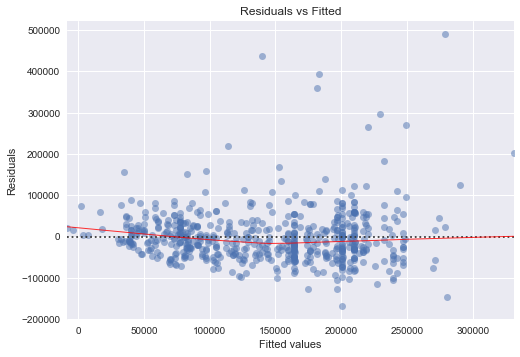

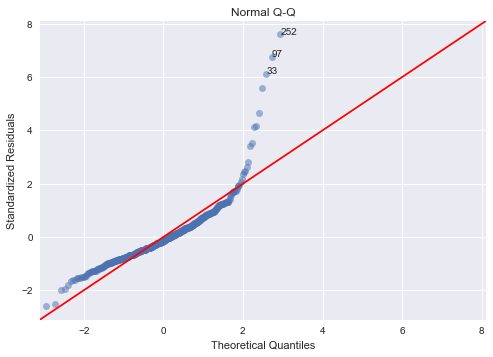

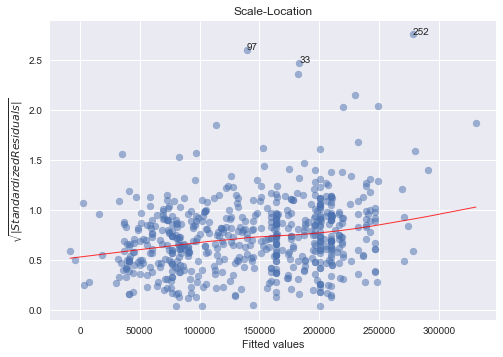

In [123]:
import statsmodels.api as sm 
from statsmodels.graphics.gofplots import ProbPlot
plt.style.use('seaborn')

y = data['salary_in_cad']
X = data.drop(columns='salary_in_cad')

# generate OLS model
model = sm.OLS(y, sm.add_constant(X))
model_fit = model.fit()

# create dataframe from X, y for easier plot handling
diagnostic_plot_df = pd.concat([X, y], axis=1)

model_fitted_y = model_fit.fittedvalues
# model residuals
model_residuals = model_fit.resid
# normalized residuals
model_norm_residuals = model_fit.get_influence().resid_studentized_internal
# absolute squared normalized residuals
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))
# absolute residuals
model_abs_resid = np.abs(model_residuals)
# leverage, from statsmodels internals
model_leverage = model_fit.get_influence().hat_matrix_diag
# cook's distance, from statsmodels internals
model_cooks = model_fit.get_influence().cooks_distance[0]

plot_lm_1 = plt.figure()
plot_lm_1.axes[0] = sns.residplot(model_fitted_y, diagnostic_plot_df.columns[-1], data=diagnostic_plot_df,
                          lowess=True,
                          scatter_kws={'alpha': 0.5},
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_1.axes[0].set_title('Residuals vs Fitted')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals');

QQ = ProbPlot(model_norm_residuals)
plot_lm_2 = QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1)
plot_lm_2.axes[0].set_title('Normal Q-Q')
plot_lm_2.axes[0].set_xlabel('Theoretical Quantiles')
plot_lm_2.axes[0].set_ylabel('Standardized Residuals');
# annotations
abs_norm_resid = np.flip(np.argsort(np.abs(model_norm_residuals)), 0)
abs_norm_resid_top_3 = abs_norm_resid[:3]
for r, i in enumerate(abs_norm_resid_top_3):
    plot_lm_2.axes[0].annotate(i,
                               xy=(np.flip(QQ.theoretical_quantiles, 0)[r],
                                   model_norm_residuals[i]));

plot_lm_3 = plt.figure()
plt.scatter(model_fitted_y, model_norm_residuals_abs_sqrt, alpha=0.5);
sns.regplot(model_fitted_y, model_norm_residuals_abs_sqrt,
            scatter=False,
            ci=False,
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8});
plot_lm_3.axes[0].set_title('Scale-Location')
plot_lm_3.axes[0].set_xlabel('Fitted values')
plot_lm_3.axes[0].set_ylabel('$\sqrt{|Standardized Residuals|}$');

# annotations
abs_sq_norm_resid = np.flip(np.argsort(model_norm_residuals_abs_sqrt), 0)
abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:3]
for i in abs_norm_resid_top_3:
    plot_lm_3.axes[0].annotate(i,
                                xy=(model_fitted_y[i],
                                    model_norm_residuals_abs_sqrt[i]));

As you can see, the QQ plot indicates non-normality of residuals, scale-location plot shows potential non-linearity, and residual-fitted plot exhibits slight heteroskedasticity. My approach is to transform `salary_in_cad` in log 10 and remove outliers and hopefully that would resolve issues.

Why log 10? In general, transformations affects interpretation of results but fortunately a log transform is fairly easy to interpret. Since we tend to think of salaries in terms of powers of 10 (e.g. 5 figure or 6 figure salaries) it doesn't take too much cognitive effort to evaluate our response-- a transformed value of 4 and 5 would corresponde to an original value of 10k and 100k salary, respectively.

<AxesSubplot:xlabel='salary_in_cad'>

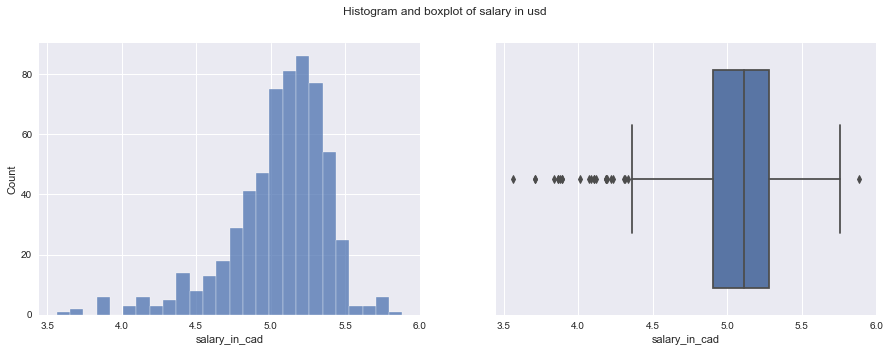

In [125]:
data['salary_in_cad'] = np.log10(data['salary_in_cad']) # converts our response variable
plt.rcParams['figure.figsize'] = [15, 5]
fig, ax =plt.subplots(1,2)
fig.suptitle('Histogram and boxplot of transformed salary in cad')
sns.histplot(x='salary_in_cad', data=data, ax=ax[0])
sns.boxplot(x='salary_in_cad', data=data, ax=ax[1])


Our transformed response is now left skewed, 

"test2 = test[(test['employment_type_FT']==1) & (test['salary_in_cad'] >= 4.4)]\nsns.histplot(test2['salary_in_cad'])"

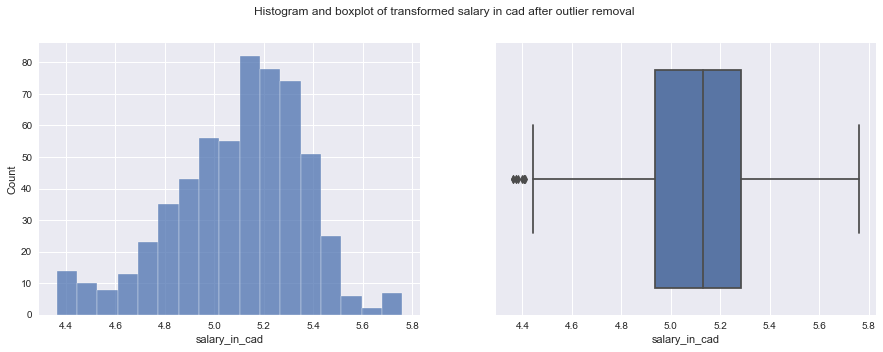

In [133]:
from scipy import stats
Q1 = data['salary_in_cad'].quantile(0.25)
Q3 = data['salary_in_cad'].quantile(0.75)
IQR = Q3-Q1 
data = data[(data['salary_in_cad'] >= Q1-1.5*IQR) & (data['salary_in_cad'] <= Q3+1.5*IQR)]

fig, ax =plt.subplots(1,2)
fig.suptitle('Histogram and boxplot of transformed salary in cad after outlier removal')
sns.histplot(x='salary_in_cad', data=data, ax=ax[0])
sns.boxplot(x='salary_in_cad', data=data, ax=ax[1])

"""test2 = test[(test['employment_type_FT']==1) & (test['salary_in_cad'] >= 4.4)]
sns.histplot(test2['salary_in_cad'])"""

In [134]:
data.shape

(582, 17)

Oddly enough, there are still some datapoints outside of the IQR range. However, we've already removed 20 data points and the supposed 'outliers' are all around 4.4, which is good since that's around where the minimum wage in Canada is. What's important is the outlook of the diagnostic plots.  

/Users/danielyang/Library/Caches/pypoetry/virtualenvs/smart-technologies-interview-presentation-FMutRnCN-py3.10/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/danielyang/Library/Caches/pypoetry/virtualenvs/smart-technologies-interview-presentation-FMutRnCN-py3.10/lib/python3.10/site-packages/statsmodels/graphics/gofplots.py:1045: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


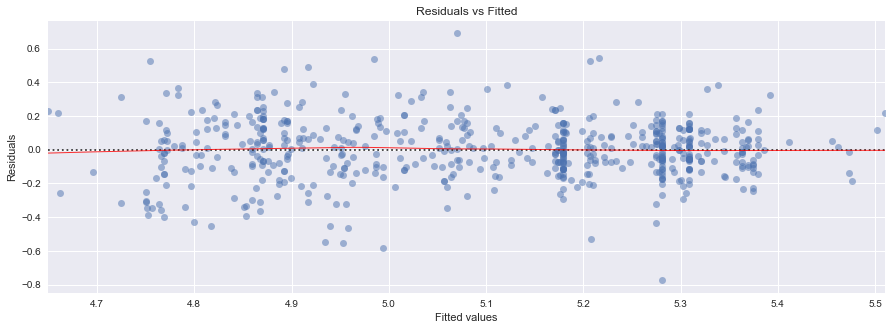

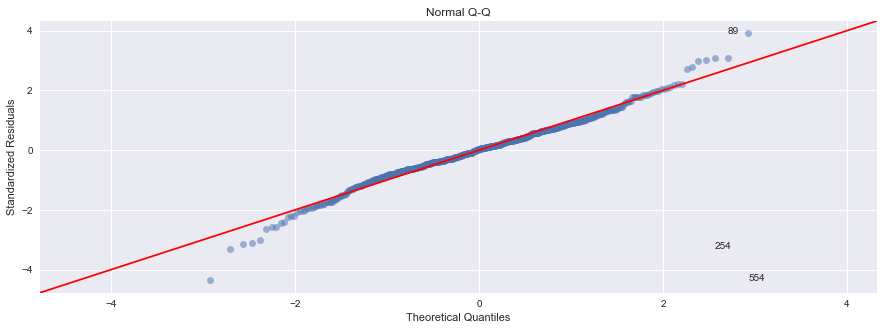

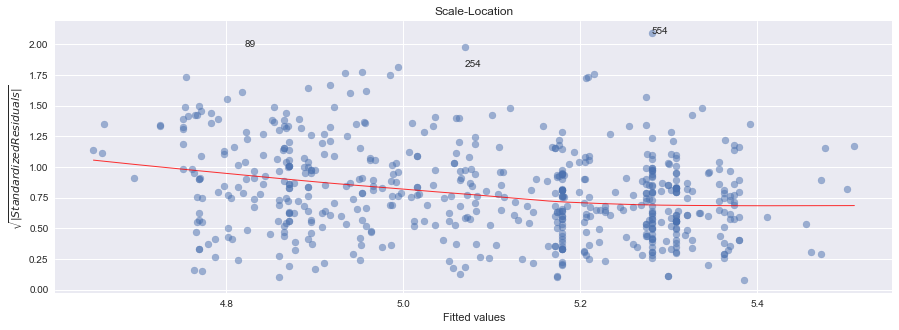

In [135]:
y = data['salary_in_cad']
X = data.drop(columns='salary_in_cad')

# generate OLS model
model = sm.OLS(y, sm.add_constant(X))
model_fit = model.fit()

# create dataframe from X, y for easier plot handling
diagnostic_plot_df = pd.concat([X, y], axis=1)

model_fitted_y = model_fit.fittedvalues
# model residuals
model_residuals = model_fit.resid
# normalized residuals
model_norm_residuals = model_fit.get_influence().resid_studentized_internal
# absolute squared normalized residuals
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))
# absolute residuals
model_abs_resid = np.abs(model_residuals)
# leverage, from statsmodels internals
model_leverage = model_fit.get_influence().hat_matrix_diag
# cook's distance, from statsmodels internals
model_cooks = model_fit.get_influence().cooks_distance[0]

plot_lm_1 = plt.figure()
plot_lm_1.axes[0] = sns.residplot(model_fitted_y, diagnostic_plot_df.columns[-1], data=diagnostic_plot_df,
                          lowess=True,
                          scatter_kws={'alpha': 0.5},
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_1.axes[0].set_title('Residuals vs Fitted')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals');

QQ = ProbPlot(model_norm_residuals)
plot_lm_2 = QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1)
plot_lm_2.axes[0].set_title('Normal Q-Q')
plot_lm_2.axes[0].set_xlabel('Theoretical Quantiles')
plot_lm_2.axes[0].set_ylabel('Standardized Residuals');
# annotations
abs_norm_resid = np.flip(np.argsort(np.abs(model_norm_residuals)), 0)
abs_norm_resid_top_3 = abs_norm_resid[:3]
for r, i in enumerate(abs_norm_resid_top_3):
    plot_lm_2.axes[0].annotate(i,
                               xy=(np.flip(QQ.theoretical_quantiles, 0)[r],
                                   model_norm_residuals[i]));

plot_lm_3 = plt.figure()
plt.scatter(model_fitted_y, model_norm_residuals_abs_sqrt, alpha=0.5);
sns.regplot(model_fitted_y, model_norm_residuals_abs_sqrt,
            scatter=False,
            ci=False,
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8});
plot_lm_3.axes[0].set_title('Scale-Location')
plot_lm_3.axes[0].set_xlabel('Fitted values')
plot_lm_3.axes[0].set_ylabel('$\sqrt{|Standardized Residuals|}$');

# annotations
abs_sq_norm_resid = np.flip(np.argsort(model_norm_residuals_abs_sqrt), 0)
abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:3]
for i in abs_norm_resid_top_3:
    plot_lm_3.axes[0].annotate(i,
                                xy=(model_fitted_y[i],
                                    model_norm_residuals_abs_sqrt[i]));

There we go. Much nicer.

We are now (finally) ready to fit some models to the data!

# 3. Model fitting

## 3.a. OLS (Ol' Reliable)

There are several reasons why I'd start with OLS even though there are other models that generally outperform it in terms of model predictions: the $\hat\beta$ coefficients are easily explainable, we get standard errors, the model is optimal for MSE etc.  

The coefficients also have a nice property in that as you increase sample size, $\hat\beta \rightarrow \beta$ by the weak law of large numbers (this is more obvious if you recall that $\beta \sim N(\beta, \sigma^2/n)$ -- thanks CLT!)

And yes, this part links my data project to CLT. In retrospect, I should have selected a dataset where I could simulate different data and do some improptu A/B tests (or equivalently z-testing/t-testing) for a more useful/obvious applicaton, but we all make mistakes.

In [136]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from yellowbrick.regressor import ResidualsPlot

# I use statsmodels instead of sklearn to get the familiar summary output for those of you who have previously coded in R 
y = data['salary_in_cad']
X = data.drop(columns='salary_in_cad')
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=0) # for reproducability purposes

# generate OLS model
sm_linreg_model = sm.OLS(y_train, sm.add_constant(X_train)).fit()
print(sm_linreg_model.summary())


                            OLS Regression Results                            
Dep. Variable:          salary_in_cad   R-squared:                       0.556
Model:                            OLS   Adj. R-squared:                  0.541
Method:                 Least Squares   F-statistic:                     35.12
Date:                Fri, 12 Aug 2022   Prob (F-statistic):           8.98e-69
Time:                        11:11:11   Log-Likelihood:                 146.22
No. Observations:                 465   AIC:                            -258.4
Df Residuals:                     448   BIC:                            -188.0
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

No obvious problems stemming from the summary and is quite informative of what our features are doing and how well our model does (to see full output, please run and view output in a text editor as per the line)! Some things that stand out:

- Experience level is significant and positive (passes the sanity check)
- Job titles are also all significant, indicating each group having different average salaries
- Salaries in USA are on average higher
- Employment type (except freelance/contract work), work years, remote ratio and company location matching employee residence are not important

The training R^2 stands at a passable 0.556 (or 0.541 if you are more in favor of adjusted R^2). What about the predictions?

Coefficients: 
 [ 0.10669023  0.01879216 -0.03514076 -0.02855469 -0.48137839 -0.19299302
 -0.21946702 -0.28371266  0.17101199 -0.00977975 -0.00158681 -0.15043525
  0.10459686  0.19778543  0.12030526  0.17935705]
Mean squared error: 0.03
Mean absolute error: 0.13
Coefficient of determination: 0.55


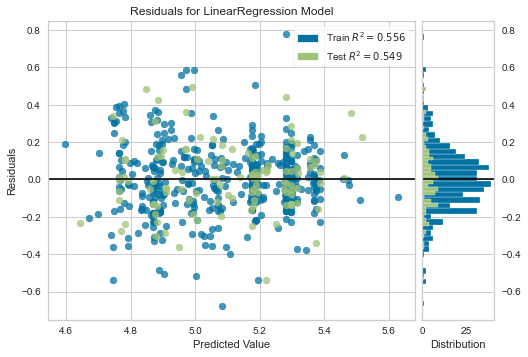

<AxesSubplot:title={'center':'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [137]:
# Run the same model again in sklearn's linear regression to cross check results. Also I get a cool plot
lin_reg = LinearRegression().fit(X_train, y_train)
lin_reg.score(X_train, y_train)
y_pred = lin_reg.predict(X_test)

#print(X_train)
# The coefficients
print("Coefficients: \n", lin_reg.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
# The mean abs. error
print("Mean absolute error: %.2f" % mean_absolute_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))

visualizer = ResidualsPlot(LinearRegression())
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

As expected, test R^2 does slightly worse. However MSE and MAE values are very promising!

## 3.b. Ridge/LASSO

Similar to OLS, but adds a penalty term to regularize (reduces variance at the cost of some bias) the model. Non-significant or low impact covariates will be shrunk in these kinds of regressions(The difference between Ridge and LASSO are the type of penalty used). In general, we should expect to see an improved predictive model (higher R^2 and lower MSE/MAE), but we wouldn't be able to interpret the coefficients. There's also a hyperparameter $\alpha$ in the model that we would need to tune for more optimal results.

For those familiar with these types of models, you might ask how is it that I'm able to run these types of regression without standardizing/scaling my predictors (which is necessary for these models to work in the way the penalty interacts with the model). Well, all the predictors here are categorical, and so it wouldn't make sense to do so. 

First up, Ridge regression:

Coefficients: 
 [ 0.10704907  0.01881392 -0.02851009 -0.02725922 -0.11892702  0.00036108
 -0.01492596 -0.10314173  0.16191729 -0.00952257  0.00155521  0.03722502
  0.083043    0.15594518  0.101299    0.15512061]
Mean squared error: 0.03
Mean absolute error: 0.13
Coefficient of determination: 0.57


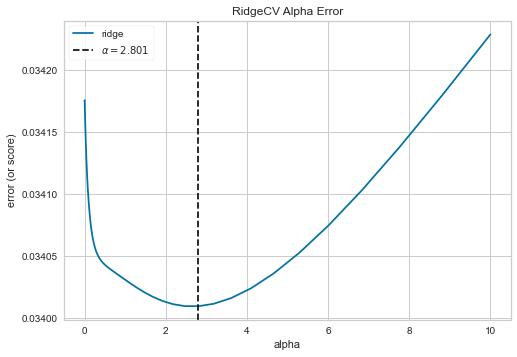

<AxesSubplot:title={'center':'RidgeCV Alpha Error'}, xlabel='alpha', ylabel='error (or score)'>

In [140]:
"""Ridge Model"""

from sklearn.linear_model import RidgeCV
from yellowbrick.regressor import AlphaSelection

alphas = np.logspace(-10, 1, 200)
ridge_model = RidgeCV(alphas=alphas).fit(X_train, y_train)

ridge_model.score(X_train, y_train)
y_pred = ridge_model.predict(X_test)
# The coefficients
print("Coefficients: \n", ridge_model.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
print("Mean absolute error: %.2f" % mean_absolute_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))

model = RidgeCV(alphas=alphas)
visualizer = AlphaSelection(model)
visualizer.fit(X_train, y_train)
visualizer.show()

No changes in MSE/MAE, extremely slight improvement in R^2? It's shown the optimal $\alpha$ hyperparameter value is 2.801. 

Checking model results with LASSO:

Coefficients: 
 [ 0.1050095   0.01394878 -0.         -0.         -0.          0.
 -0.         -0.12584619  0.17243638 -0.          0.          0.
  0.05597569  0.11885688  0.07655186  0.13179868]
Mean squared error: 0.03
Mean absolute error: 0.13
Coefficient of determination: 0.57


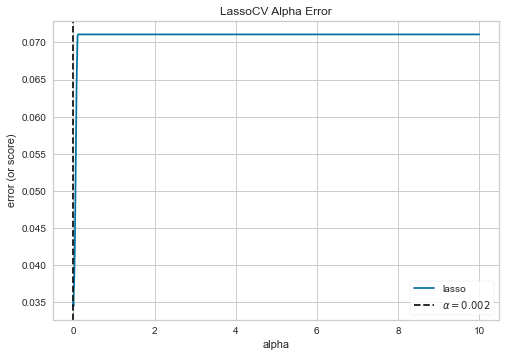

<AxesSubplot:title={'center':'LassoCV Alpha Error'}, xlabel='alpha', ylabel='error (or score)'>

In [141]:
"""LASSO"""

from sklearn.linear_model import LassoCV

lasso_model = LassoCV(cv=5, random_state=0).fit(X_train, y_train)
lasso_model.score(X_train, y_train)

y_pred = lasso_model.predict(X_test)

print("Coefficients: \n", lasso_model.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
print("Mean absolute error: %.2f" % mean_absolute_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))

model = LassoCV(alphas=alphas)
visualizer = AlphaSelection(model)
visualizer.fit(X_train, y_train)
visualizer.show()

Again, no (real) changes to MSE/MAE and R^2. The $\alpha$ selection plot here is quite interesting, since it suggests that $\alpha \approx 0$ is the best value of $\alpha$ indicating that almost no penalty should be used in the model (making OLS the most optimal kind of model) -- this contradicts the value of $\alpha$ obtained by the ridge regression. Between the 2, I'm inclined to believe that $\alpha=0$ makes more sense. Since all of these metrics are the same, I believe among the 3 models tested OLS is the best model - predictive power is virtually the same but you are also able to interpret your predictor coefficients. 

## 3.c. Random forest

Rather than limit ourselves with just linear/parametric models, below is a (non tuned) tree-based model. Random forests are very common/popular nowadays (although superceded by XGBoost and more sophisticated state of the art approaches).

We also get a chance to see a feature importance plot, which tells us the "relative importance" (predictive gains or weight I presume) of each feature.


Mean squared error: 0.03
Mean absolute error: 0.14


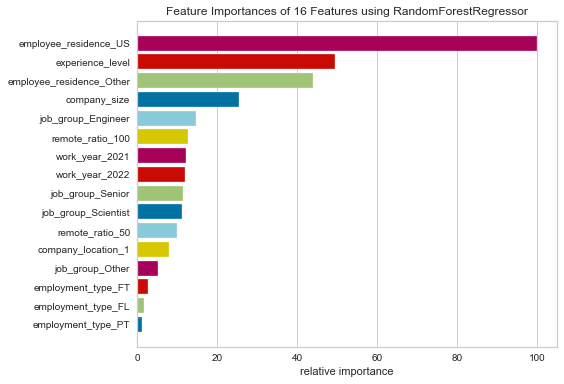

<AxesSubplot:title={'center':'Feature Importances of 16 Features using RandomForestRegressor'}, xlabel='relative importance'>

In [142]:
from sklearn.ensemble import RandomForestRegressor

from yellowbrick.datasets import load_occupancy
from yellowbrick.model_selection import FeatureImportances

rf_reg = RandomForestRegressor(random_state=0).fit(X_train,y_train)
rf_reg.fit(X_train, y_train)

y_pred = rf_reg.predict(X_test)

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
print("Mean absolute error: %.2f" % mean_absolute_error(y_test, y_pred))

model = RandomForestRegressor(random_state=0)
viz = FeatureImportances(model)
viz.fit(X_train, y_train)
viz.show()

As it turns out, the results are the same. Shame. It could be that based on my approach to the data insofar as data processing goes this is about as good as I can get it. I'm under no illusion that with better feature engineering and approaches to extract more feature columns, you'll see better metrics, but I'm quite satisfied with how my analysis turns out.

# 4. Predicting My Own Salary

Time for a logos == bios test. I'll fit a sample data point with characteristics matching myself and see what I get (consequences be damned).

In [145]:
# first check what the input orders are
X.head()


,experience_level,company_size,work_year_2021,work_year_2022,employment_type_FL,employment_type_FT,employment_type_PT,employee_residence_Other,employee_residence_US,remote_ratio_50,remote_ratio_100,company_location_1,job_group_Engineer,job_group_Other,job_group_Scientist,job_group_Senior
0,1.0,2.0,0,0,0,1,0,1,0,0,0,0,0,0,1,0
1,2.0,0.0,0,0,0,1,0,1,0,0,0,0,0,0,1,0
2,2.0,1.0,0,0,0,1,0,1,0,1,0,0,1,0,0,0
3,1.0,0.0,0,0,0,1,0,1,0,0,0,0,0,0,0,0
4,2.0,2.0,0,0,0,1,0,0,1,1,0,1,1,0,0,0


In [146]:
my_data_point = np.array([0,1.0,0,1,0,1,0,0,0,0,1,1,0,0,1,0])
my_data_point_pred = lin_reg.predict(my_data_point.reshape(1,-1))
print(my_data_point_pred)
print(10**my_data_point_pred)

[4.9123587]
[81725.71051797]


/Users/danielyang/Library/Caches/pypoetry/virtualenvs/smart-technologies-interview-presentation-FMutRnCN-py3.10/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Well, seems like my model would predict a salary of 81k, which seems reasonable! If it was too outlandish or low I'd respond with a pithy quote about how all models are wrong but some are useful but in this case it's not and so forth.

# 5. Summary and closing thoughts 

Not to rehash everything that I've done at this point, but I've illustrated my attempt at making a reasonably thorough data analysis project and did my best to describe all of my thought process. EDA, Data processing, and model fitting are the core of what I've done. Emphasis placed on actually writing vectorized code and briefly explaining how CLT fits in all of this.

I had planned for a much larger showcase (dashboards, Bayesian analysis in R, simulations to check for robustness, potentially even monitoring tools), actually...but given the time constraints (and admittedly, shaking off the rust because it's been a while since I've done something Kaggle-esque) this was all I was able to do. Hope it's been satisfactory!

### Huge thanks for letting me do this! 

I was really not presenting my best in the one-way video interview, so thanks again.
